In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import time
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings('ignore')

In [3]:
def load_data(filename, num_of_features, num_of_target_class, values_dict = {}, train_data = False):
    df = np.asarray(pd.read_csv(filename, header=None, dtype=int))
    df = df[df[:,-1] < num_of_target_class]
    
    Y = df[:,-1]
    df = df[:,0:df.shape[1]-1]
    
    y = np.zeros((df.shape[0],len(list(set(list(Y))))))
    
    df = df[:, 0:num_of_features]

    count = 0
    if values_dict == {}:
        for i in range(df.shape[1]):
            length = len(list(set(list(df[:,i]))))
            values_dict[i] = length
            count += length
        x = np.zeros((df.shape[0],count))
    else:
        x = np.zeros((df.shape[0],sum(values_dict.values())))
    
    for j in range(df.shape[0]):
        ohe_encoded = []
        y[j][Y[j]] = 1
        for i in range(df.shape[1]):
            val = df[j][i]
            ohe_mat = np.zeros((values_dict[i]))
            ohe_mat[val-1] = 1
            ohe_encoded.extend(ohe_mat)
        ohe_encoded = np.asarray(ohe_encoded)
        x[j] = ohe_encoded

    if train_data == True:
        return x,y,values_dict
    else:
        return x,y

In [4]:
BATCH_SIZE = 100
NUMBER_OF_FEATURES = 10
HIDDEN_LAYERS_UNITS = [5]
NUMBER_OF_TARGET_CLASS = 10
NUMBER_OF_OUTPUTS = NUMBER_OF_TARGET_CLASS

LEARNING_RATE = 0.1
EPSILON = 0.0001
MIN_LOSS = 0.01
tolerance = 0.001
EPOCHS = 100

In [5]:
PART = 'a'
BASE_DIR = '../'

train_path = os.path.join(BASE_DIR, 'data', 'Poker_Hand_dataset', 'poker-hand-training-true.data')
test_path  = os.path.join(BASE_DIR, 'data', 'Poker_Hand_dataset', 'poker-hand-testing.data')

# if PART == 'a':

Xtrain, Ytrain, values_dict = load_data(train_path, NUMBER_OF_FEATURES, NUMBER_OF_TARGET_CLASS, train_data=True)
Xtest, Ytest = load_data(test_path, NUMBER_OF_FEATURES, NUMBER_OF_TARGET_CLASS, values_dict)

In [6]:
class NN_architecture:
    def __init__(self, learning_rate, batch_size, num_of_features, hidden_layer_units, num_of_outputs, MIN_LOSS, epsilon, adaptive_learning = False):
        self.learning_rate = learning_rate
        self.init_learning_rate = learning_rate
        self.batch_size = batch_size
        self.num_of_features = num_of_features
        self.hidden_layer_list = hidden_layer_units
        self.num_of_outputs = num_of_outputs
        self.MIN_LOSS = MIN_LOSS
        self.epsilon = epsilon
        self.learning_rate_threshold = 1e-5 # Min possible learning rate
        self.adaptive = adaptive_learning
    
    def sigmoid_activation(self,data):
        return (1.0/(1.0 + np.exp(-data)) )
    
    def relu_activation(self,data):
        return np.multiply(data>0,data)
    
    def sigmoid_der(self,data):
        # x = self.sigmoid_activation(data)
        x = data
        return np.multiply(x,1.0-x)
    
    def relu_der(self,data):
        temp = np.ones(data.shape,dtype=float)
        return np.multiply(temp>0,temp)
    
    def initialize(self):
        neuron_count = [self.num_of_inputs]
        neuron_count.extend(self.hidden_layer_list)
        neuron_count.append(self.num_of_outputs)
        self.neuron_count = neuron_count
        params = {}
        np.random.seed(1)
        
        # xavier initialization
        for i in range(1, len(neuron_count)):
            params["W" + str(i)] = np.random.normal(0,1,(neuron_count[i],neuron_count[i-1]))*np.sqrt(2.0/neuron_count[i-1])
            params["b" + str(i)] = np.zeros((neuron_count[i],1),dtype=float)
        
        self.params = params
        self.num_of_layers = len(neuron_count)
        
        return
    
    def forward_propagation(self, X, activation_function):        
        forward_prop = {}
        data = (X.T).copy()
        forward_prop["a0"] = data # n*m

        for i in range(self.num_of_layers-2):
            data = np.dot(self.params["W"+str(i+1)], data) + self.params["b"+str(i+1)]

            if activation_function == "relu":
                data = self.relu_activation(data)
            elif activation_function == "sigmoid":
                data = self.sigmoid_activation(data)

            forward_prop["a"+str(i+1)] = data.copy()
        
        data = np.dot(self.params["W"+str(self.num_of_layers-1)], data) + self.params["b"+str(self.num_of_layers-1)]
        data = self.sigmoid_activation(data)
        forward_prop["a"+str(self.num_of_layers-1)] = data.copy()

        self.forward_prop = forward_prop
        return
    
    def backward_propagation(self, Y, activation_function):
        self.backward_prop = {}
        dataY = (Y.T).copy()
        
        self.backward_prop["dz"+str(self.num_of_layers-1)] = self.forward_prop["a" + str(self.num_of_layers-1)] - dataY
        
        for i in range(self.num_of_layers-2,0,-1):
            temp_mat = np.dot(self.params["W"+str(i+1)].T, self.backward_prop["dz"+str(i+1)])
            
            if activation_function == "sigmoid":
                temp_mat =np.multiply(temp_mat, self.sigmoid_der(self.forward_prop["a"+str(i)]))
            elif activation_function == "relu":
                temp_mat =np.multiply(temp_mat, self.relu_der(self.forward_prop["a"+str(i)]))
                
            self.backward_prop["dz"+str(i)] = temp_mat
        
        # i = self.num_of_layers-2
        # while i>=0:
        #     temp_mat = np.dot(self.params["W"+str(i+1)].T, backward_prop["dz" + str(i+1)])
            
        #     if activation_function == "sigmoid":
        #         temp_mat = np.multiply(temp_mat, self.sigmoid_der(self.forward_prop["a"+str(i)]))
        #     elif activation_function == "relu":
        #         temp_mat = np.multiply(temp_mat, self.relu_der(self.forward_prop["a"+str(i)]))
                
        #     backward_prop["dz" + str(i)] = temp_mat            
        #     i-=1
        # self.backward_prop = backward_prop
        # return
    
    def backward_propagation2(self, Y, activation_function):
        self.backward_prop = {}
        dataY = (Y.T).copy()
        
        temp_mat = np.multiply(dataY - self.forward_prop["a"+str(self.num_of_layers-1)], self.forward_prop["a"+str(self.num_of_layers-1)])
        temp_mat = np.multiply(temp_mat, (1-self.forward_prop["a"+str(self.num_of_layers-1)]) )
        
        self.backward_prop["dz"+str(self.num_of_layers-1)] = temp_mat
        
        for i in range(self.num_of_layers-2, 0, -1):
            if activation_function == "sigmoid":
                temp_mat = np.multiply(self.params["W"+str(i+1)].T @ self.backward_prop["dz"+str(i+1)], self.forward_prop["a"+str(i)] * (1-self.forward_prop["a"+str(i)]) )
            elif activation_function == "relu":
                temp_mat = temp_mat = np.multiply(self.params["W"+str(i+1)].T @ self.backward_prop["dz"+str(i+1)], np.multiply(self.forward_prop["a"+str(i)] > 0, self.forward_prop["a"+str(i)]) )
        
            self.backward_prop["dz"+str(i)] = temp_mat
        return
    
    def update_params(self,M):
        new_params = {}
        for i in range(1,self.num_of_layers):
            new_params["W"+str(i)] = self.params["W"+str(i)] - (self.learning_rate/M)*np.dot(self.backward_prop["dz"+str(i)],(self.forward_prop["a"+str(i-1)]).T)
            
            temp = (self.learning_rate/M)*np.sum(self.backward_prop["dz"+str(i)],axis=1)
            temp = temp.reshape((temp.shape[0],1))
            

            new_params["b"+str(i)] = self.params["b"+str(i)] - temp

        self.params = new_params
        return
    
    def predict(self,X,activation_function="sigmoid"):
        data_x = (X.T).copy()
        for i in range(1,self.num_of_layers):
            data_x = np.add(np.dot(self.params["W"+str(i)],data_x),self.params["b"+str(i)])
            if activation_function == "sigmoid":
                data_x = self.sigmoid_activation(data_x)
                
            elif activation_function == "relu":
                data_x = self.relu_activation(data_x)    
        
        data_x = self.sigmoid_activation(data_x)
        data_x = data_x.T
        data_x = data_x/(np.sum(data_x,axis=1).reshape(data_x.shape[0],1))
                
        return data_x, np.argmax(data_x,axis=1)
    
    def loss_function(self,y1,y2):
        # print(y1,y2)
        y = np.abs(y1-y2)
        y = np.multiply(y,y)
        return np.sum(y)/(2*y.shape[0])
    
    def print_param(self, i):
        print("Iteration: {}".format(i))
        for i in self.params:
            print(i,np.max(self.params[i]), np.min(self.params[i]), self.params[i].shape)
        print()

        for i in self.backward_prop:
            print(i,np.max(self.backward_prop[i]), np.min(self.backward_prop[i]), self.backward_prop[i].shape)
        print()    

        for i in self.forward_prop:
            print(i,np.max(self.forward_prop[i]), np.min(self.forward_prop[i]), self.forward_prop[i].shape)
        print()
    
    def print_class_param(self):
        print("Batch Size: {}, Learning rate: {}, Num of layers: {}".format(self.batch_size, self.learning_rate, self.num_of_layers))
        print("Neuron count: {}".format(self.neuron_count))
    
    def entropy_loss(self, y1, y2):
        
        # Here y2 is the actual Y
        # y1 is the predicted y
        l1 = np.log(np.multiply(1, y1==0) + y1)
        l1 = np.multiply(l1, y2)
        
        l2 = np.log(np.multiply(1, y1==1) + 1 - y1)
        l2 = np.multiply(l2, 1-y2)
        
        l = np.mean(-1.0*l1-1.0*l2,axis=1)
        l = np.sqrt(np.sum(np.multiply(l,l)))/(2.0*y1.shape[1])
        
        return l
    
    def run(self,epochs,X,Y,activation_function):
        self.num_of_inputs = X.shape[1]
        self.examples = X.shape[0]
        self.batches = (int)(self.examples/self.batch_size)        
        self.initialize()
        # self.print_param(0)
        # self.print_class_param()
        
        iteration  = 1
        error = float("inf")        
        time_start = time.time()
        print("Training phase ... ")
        
        error_list = []
        
        while iteration <= epochs and error > self.epsilon and self.learning_rate > self.learning_rate_threshold:
            
            error = 0
            for batch in range(self.batches):
                start = batch*self.batch_size
                end   = min(start + self.batch_size,self.examples)

                X_new = X[start:end,:]
                Y_new = Y[start:end,:]

                self.forward_propagation(X_new,activation_function)

                # self.backward_propagation2(Y_new,activation_function)
                self.backward_propagation(Y_new,activation_function)

                self.update_params(Y_new.shape[0])

                # loss_partial = self.entropy_loss(self.forward_prop["a"+str(self.num_of_layers-1)], Y_new.T)
                loss_partial = self.loss_function(self.forward_prop["a"+str(self.num_of_layers-1)], Y_new.T)
                
                error += (loss_partial)
            
            error = error/self.batches
            error_list.append(error)
            
            # Convergence criteria
            if len(error_list) > 1:
                if error_list[-1] <= self.MIN_LOSS and error_list[-2] <= self.MIN_LOSS and (abs(error_list[-1] - error_list[-2])) < (self.epsilon):
                    time_end = time.time()
                    self.training_time = (time_end - time_start)
                    return

            if iteration%200 == 0:
                print("Epoch: {}, Error: {}, Learning Rate: {}".format(iteration, error, self.learning_rate))
            iteration += 1

            if self.adaptive:
                self.learning_rate = (self.init_learning_rate)/(np.sqrt(iteration))

        time_end = time.time()
        self.training_time = (time_end - time_start)
    

In [7]:
def draw_conf_matrix(x,units, filename):
    plt.imshow(x)
    plt.title("Confusion Matrix (" + str(units) + " units)")
    plt.colorbar()
    plt.set_cmap("Greens")
    plt.ylabel("True labels")
    plt.xlabel("Predicted label")
    plt.savefig(filename)
    plt.show()

In [ ]:
hidden_layer = [[5], [10], [15], [20], [25]]
prediction = {}

for l in hidden_layer:
    temp = []
    model = NN_architecture(LEARNING_RATE, BATCH_SIZE, NUMBER_OF_FEATURES, l, NUMBER_OF_OUTPUTS, MIN_LOSS, EPSILON, False)
    model.run(1000,Xtrain, Ytrain,'sigmoid')
    t = round(model.training_time,3)
    print("Training time: {}s".format(t))
    
    y_class_train, y_pred_train = model.predict(Xtrain,'sigmoid')
    error = model.loss_function(y_class_train, Ytrain)
    train_a = round(100*accuracy_score(y_pred_train, np.argmax(Ytrain,axis=1)),3)
    print("Train Accuracy: {}%, Error: {}".format(train_a, error))

    y_class_test, y_pred_test = model.predict(Xtest,'sigmoid')
    error2 = model.loss_function(y_class_test, Ytest)
    test_a = round(100*accuracy_score(y_pred_test, np.argmax(Ytest,axis=1)),3)
    print("Test Accuracy: {}%, Error: {}".format(test_a, error2))

    y_conf = np.argmax(Ytest, axis=1)
    confusion_matrix = np.zeros((NUMBER_OF_TARGET_CLASS,NUMBER_OF_TARGET_CLASS))
    for i in range(Ytest.shape[0]):
        confusion_matrix[y_conf[i]][y_pred_test[i]] += 1

    confusion_matrix = confusion_matrix.astype(int)
    temp = [t, train_a, test_a, confusion_matrix]
    prediction[l[0]] = temp

    # print(confusion_matrix)
    draw_conf_matrix(confusion_matrix, l[0], "../output/conf_matrix_" + str(l[0]) + ".jpg")


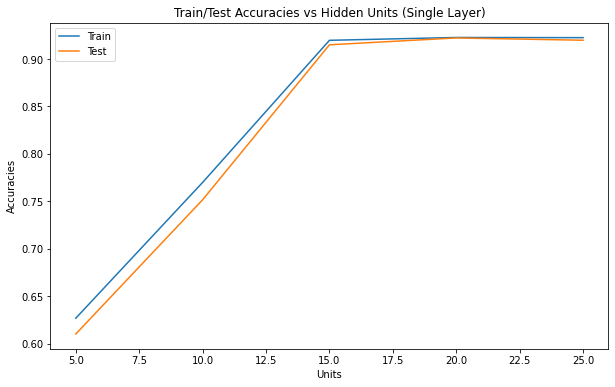

In [ ]:
train_acc = []
test_acc  = []
time_list = []

for i in prediction:
    time_list.append(prediction[i][0])
    train_acc.append((prediction[i][1])/100.0)
    test_acc.append((prediction[i][2])/100.0)

def graph_plot(y1, y2, filename):
    x = [5, 10, 15, 20, 25]
    plt.figure(figsize=(10, 6))    
    
    plt.title("Train/Test Accuracies vs Hidden Units (Single Layer)")
    plt.xlabel("Units")
    plt.ylabel("Accuracies")
    plt.plot(x, y1,label="Train")
    plt.plot(x, y2,label="Test")
    plt.legend()
    plt.savefig(filename)    
    plt.show()

graph_plot(train_acc, test_acc, "../output/nn_accuracy_vs_hidden_units_normal.jpg")


Training phase ... 
Epoch: 200, Error: 2.8392280755757056, Learning Rate: 0.007071067811865475
Epoch: 400, Error: 2.8374542732863217, Learning Rate: 0.005
Epoch: 600, Error: 2.835579650638119, Learning Rate: 0.004082482904638631
Epoch: 800, Error: 2.833865302513242, Learning Rate: 0.0035355339059327377
Epoch: 1000, Error: 2.832283655486758, Learning Rate: 0.0031622776601683794
Training time: 40.837s
Train Accuracy: 50.652%, Error: 0.43477640107082327
Test Accuracy: 50.39%, Error: 0.4348068126975044


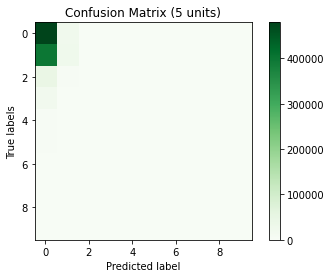

Training phase ... 
Epoch: 200, Error: 2.834621207070481, Learning Rate: 0.007071067811865475
Epoch: 400, Error: 2.831384191053025, Learning Rate: 0.005
Epoch: 600, Error: 2.828178513849661, Learning Rate: 0.004082482904638631
Epoch: 800, Error: 2.8243314379458133, Learning Rate: 0.0035355339059327377
Epoch: 1000, Error: 2.8192609908285258, Learning Rate: 0.0031622776601683794
Training time: 39.54s
Train Accuracy: 51.347%, Error: 0.43469047562402857
Test Accuracy: 50.624%, Error: 0.4347486856207411


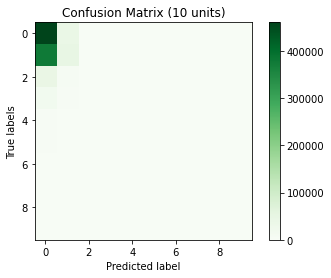

Training phase ... 
Epoch: 200, Error: 2.834592506746938, Learning Rate: 0.007071067811865475
Epoch: 400, Error: 2.83201585272146, Learning Rate: 0.005
Epoch: 600, Error: 2.8299714355876517, Learning Rate: 0.004082482904638631
Epoch: 800, Error: 2.8277058721770705, Learning Rate: 0.0035355339059327377
Epoch: 1000, Error: 2.8248148195816425, Learning Rate: 0.0031622776601683794
Training time: 44.281s
Train Accuracy: 50.552%, Error: 0.4347229180447158
Test Accuracy: 49.807%, Error: 0.434781507122563


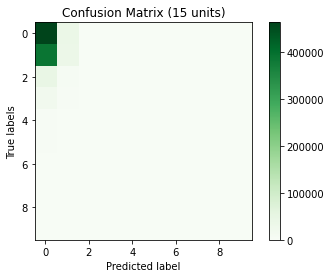

Training phase ... 
Epoch: 200, Error: 2.8330767994170545, Learning Rate: 0.007071067811865475
Epoch: 400, Error: 2.83021377921262, Learning Rate: 0.005
Epoch: 600, Error: 2.8271806997038533, Learning Rate: 0.004082482904638631
Epoch: 800, Error: 2.8231038072146326, Learning Rate: 0.0035355339059327377
Epoch: 1000, Error: 2.8173598069926786, Learning Rate: 0.0031622776601683794
Training time: 45.443s
Train Accuracy: 51.303%, Error: 0.43468211493522285
Test Accuracy: 50.416%, Error: 0.4347511370360416


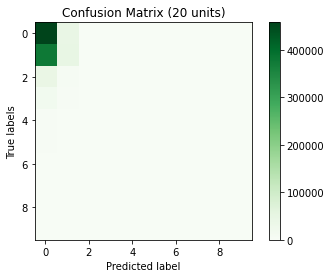

Training phase ... 
Epoch: 200, Error: 2.8344336720401193, Learning Rate: 0.007071067811865475
Epoch: 400, Error: 2.833075582245527, Learning Rate: 0.005
Epoch: 600, Error: 2.8322757600067248, Learning Rate: 0.004082482904638631
Epoch: 800, Error: 2.831586455911905, Learning Rate: 0.0035355339059327377
Epoch: 1000, Error: 2.830885151171338, Learning Rate: 0.0031622776601683794
Training time: 43.533s
Train Accuracy: 50.212%, Error: 0.4347553756707427
Test Accuracy: 49.475%, Error: 0.4348082919823125


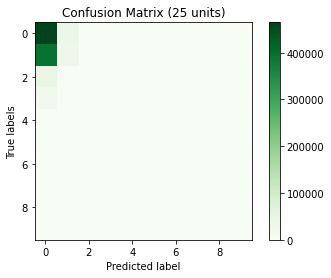

In [32]:
# ADAPTIVE LEARNING

hidden_layer = [[5], [10], [15], [20], [25]]
prediction = {}

ADAPTIVE_LEARNING = True
EPOCHS = 1000

for l in hidden_layer:
    temp = []
    model = NN_architecture(LEARNING_RATE, BATCH_SIZE, NUMBER_OF_FEATURES, l, NUMBER_OF_OUTPUTS, MIN_LOSS, EPSILON, ADAPTIVE_LEARNING)
    model.run(EPOCHS,Xtrain, Ytrain,'sigmoid')
    t = round(model.training_time,3)
    print("Training time: {}s".format(t))
    
    y_class_train, y_pred_train = model.predict(Xtrain,'sigmoid')
    error = model.loss_function(y_class_train, Ytrain)
    train_a = round(100*accuracy_score(y_pred_train, np.argmax(Ytrain,axis=1)),3)
    print("Train Accuracy: {}%, Error: {}".format(train_a, error))

    y_class_test, y_pred_test = model.predict(Xtest,'sigmoid')
    error2 = model.loss_function(y_class_test, Ytest)
    test_a = round(100*accuracy_score(y_pred_test, np.argmax(Ytest,axis=1)),3)
    print("Test Accuracy: {}%, Error: {}".format(test_a, error2))

    y_conf = np.argmax(Ytest, axis=1)
    confusion_matrix = np.zeros((NUMBER_OF_TARGET_CLASS,NUMBER_OF_TARGET_CLASS))
    for i in range(Ytest.shape[0]):
        confusion_matrix[y_conf[i]][y_pred_test[i]] += 1

    confusion_matrix = confusion_matrix.astype(int)
    temp = [t, train_a, test_a, confusion_matrix]
    prediction[l[0]] = temp

    # print(confusion_matrix)
    draw_conf_matrix(confusion_matrix, l[0], "../output/conf_matrix_" + str(l[0]) + ".jpg")


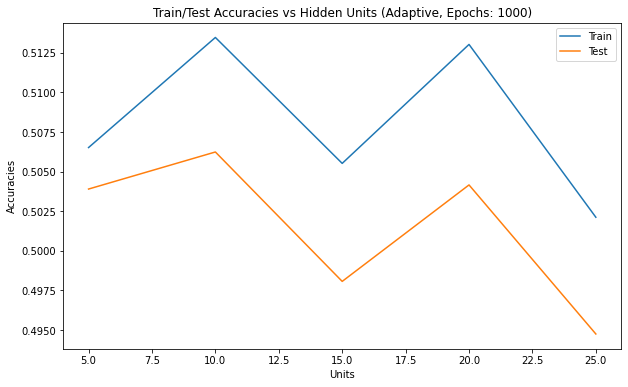

In [33]:
train_acc = []
test_acc  = []
time_list = []

for i in prediction:
    time_list.append(prediction[i][0])
    train_acc.append((prediction[i][1])/100.0)
    test_acc.append((prediction[i][2])/100.0)

def graph_plot(y1, y2, filename):
    x = [5, 10, 15, 20, 25]
    plt.figure(figsize=(10, 6))    
    
    plt.title("Train/Test Accuracies vs Hidden Units (Adaptive, Epochs: 1000)")
    plt.xlabel("Units")
    plt.ylabel("Accuracies")
    plt.plot(x, y1,label="Train")
    plt.plot(x, y2,label="Test")
    plt.legend()
    plt.savefig(filename)    
    plt.show()

graph_plot(train_acc, test_acc, "../output/nn_accuracy_vs_hidden_units_adaptive_1000.jpg")


In [9]:
# SIGMOID (2 Layers)

hidden_layer = [[100, 100]]
prediction = {}

for l in hidden_layer:
    temp = []
    model = NN_architecture(LEARNING_RATE, BATCH_SIZE, NUMBER_OF_FEATURES, l, NUMBER_OF_OUTPUTS, MIN_LOSS, EPSILON, False)
    model.run(1000,Xtrain, Ytrain,'sigmoid')
    t = round(model.training_time,3)
    print("Training time: {}s".format(t))
    
    y_class_train, y_pred_train = model.predict(Xtrain,'sigmoid')
    error = model.loss_function(y_class_train, Ytrain)
    train_a = round(100*accuracy_score(y_pred_train, np.argmax(Ytrain,axis=1)),3)
    print("Train Accuracy: {}%, Error: {}".format(train_a, error))

    y_class_test, y_pred_test = model.predict(Xtest,'sigmoid')
    error2 = model.loss_function(y_class_test, Ytest)
    test_a = round(100*accuracy_score(y_pred_test, np.argmax(Ytest,axis=1)),3)
    print("Test Accuracy: {}%, Error: {}".format(test_a, error2))

    y_conf = np.argmax(Ytest, axis=1)
    confusion_matrix = np.zeros((NUMBER_OF_TARGET_CLASS,NUMBER_OF_TARGET_CLASS))
    for i in range(Ytest.shape[0]):
        confusion_matrix[y_conf[i]][y_pred_test[i]] += 1

    confusion_matrix = confusion_matrix.astype(int)
    temp = [t, train_a, test_a, confusion_matrix]
    prediction[str(l[0])+"_"+str(l[1])] = temp

    # print(confusion_matrix)
    draw_conf_matrix(confusion_matrix, l[0], "../output/conf_matrix_2_layers_" + str(l[0]) + "_" + str(l[1]) + ".jpg")


Training phase ... 
Epoch: 200, Error: 2.836029115284043, Learning Rate: 0.1
Epoch: 400, Error: 1.627393830215, Learning Rate: 0.1
Epoch: 600, Error: 0.18115061891566797, Learning Rate: 0.1
Epoch: 800, Error: 0.056370898900369885, Learning Rate: 0.1
Epoch: 1000, Error: 0.028036685870075195, Learning Rate: 0.1
Training time: 1030.84s
Train Accuracy: 99.78%, Error: 0.41152952043367874
Test Accuracy: 98.492%, Error: 0.41213091198520657


TypeError: unhashable type: 'list'

Training phase ... 
Epoch: 200, Error: 2.837028048262982, Learning Rate: 0.007071067811865475
Epoch: 400, Error: 2.8354153918570595, Learning Rate: 0.005
Epoch: 600, Error: 2.834633032543577, Learning Rate: 0.004082482904638631
Epoch: 800, Error: 2.834177164488939, Learning Rate: 0.0035355339059327377
Epoch: 1000, Error: 2.8338711201313136, Learning Rate: 0.0031622776601683794
Training time: 728.832s
Train Accuracy: 50.096%, Error: 0.4347753850832802
Test Accuracy: 49.559%, Error: 0.4348177281485604


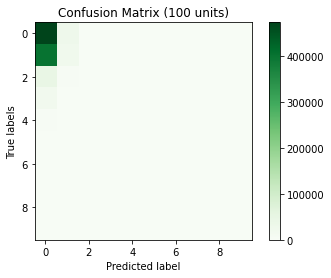

In [17]:
# SIGMOID (2 Layers, Adaptive Learning Rate)

hidden_layer = [[100, 100]]
prediction = {}

for l in hidden_layer:
    temp = []
    model = NN_architecture(LEARNING_RATE, BATCH_SIZE, NUMBER_OF_FEATURES, l, NUMBER_OF_OUTPUTS, MIN_LOSS, EPSILON, True)
    model.run(1000,Xtrain, Ytrain,'sigmoid')
    t = round(model.training_time,3)
    print("Training time: {}s".format(t))
    
    y_class_train, y_pred_train = model.predict(Xtrain,'sigmoid')
    error = model.loss_function(y_class_train, Ytrain)
    train_a = round(100*accuracy_score(y_pred_train, np.argmax(Ytrain,axis=1)),3)
    print("Train Accuracy: {}%, Error: {}".format(train_a, error))

    y_class_test, y_pred_test = model.predict(Xtest,'sigmoid')
    error2 = model.loss_function(y_class_test, Ytest)
    test_a = round(100*accuracy_score(y_pred_test, np.argmax(Ytest,axis=1)),3)
    print("Test Accuracy: {}%, Error: {}".format(test_a, error2))

    y_conf = np.argmax(Ytest, axis=1)
    confusion_matrix = np.zeros((NUMBER_OF_TARGET_CLASS,NUMBER_OF_TARGET_CLASS))
    for i in range(Ytest.shape[0]):
        confusion_matrix[y_conf[i]][y_pred_test[i]] += 1

    confusion_matrix = confusion_matrix.astype(int)
    temp = [t, train_a, test_a, confusion_matrix]
    prediction[str(l[0])+"_"+str(l[1])] = temp

    # print(confusion_matrix)
    draw_conf_matrix(confusion_matrix, l, "../output/conf_matrix_2_layers_adaptive_sigmoid_" + str(l[0]) + "_" + str(l[1]) + ".jpg")


Training phase ... 
Epoch: 200, Error: 2.8123015308822534, Learning Rate: 0.007071067811865475
Epoch: 400, Error: 2.8067005093065087, Learning Rate: 0.005
Epoch: 600, Error: 2.8021125302895302, Learning Rate: 0.004082482904638631
Epoch: 800, Error: 2.798814220800827, Learning Rate: 0.0035355339059327377
Epoch: 1000, Error: 2.79620985573152, Learning Rate: 0.0031622776601683794
Training time: 583.187s
Train Accuracy: 51.06%, Error: 0.4471617730315248
Test Accuracy: 50.436%, Error: 0.4473279720032957


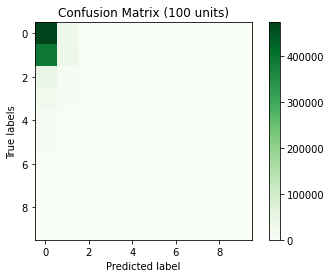

In [18]:
# Relu (2 Layers, Adaptive Learning Rate)

hidden_layer = [[100, 100]]
prediction = {}

for l in hidden_layer:
    temp = []
    model = NN_architecture(LEARNING_RATE, BATCH_SIZE, NUMBER_OF_FEATURES, l, NUMBER_OF_OUTPUTS, MIN_LOSS, EPSILON, True)
    model.run(1000,Xtrain, Ytrain,'relu')
    t = round(model.training_time,3)
    print("Training time: {}s".format(t))
    
    y_class_train, y_pred_train = model.predict(Xtrain,'relu')
    error = model.loss_function(y_class_train, Ytrain)
    train_a = round(100*accuracy_score(y_pred_train, np.argmax(Ytrain,axis=1)),3)
    print("Train Accuracy: {}%, Error: {}".format(train_a, error))

    y_class_test, y_pred_test = model.predict(Xtest,'relu')
    error2 = model.loss_function(y_class_test, Ytest)
    test_a = round(100*accuracy_score(y_pred_test, np.argmax(Ytest,axis=1)),3)
    print("Test Accuracy: {}%, Error: {}".format(test_a, error2))

    y_conf = np.argmax(Ytest, axis=1)
    confusion_matrix = np.zeros((NUMBER_OF_TARGET_CLASS,NUMBER_OF_TARGET_CLASS))
    for i in range(Ytest.shape[0]):
        confusion_matrix[y_conf[i]][y_pred_test[i]] += 1

    confusion_matrix = confusion_matrix.astype(int)
    temp = [t, train_a, test_a, confusion_matrix]
    prediction[str(l[0])+"_"+str(l[1])] = temp

    # print(confusion_matrix)
    draw_conf_matrix(confusion_matrix, l, "../output/conf_matrix_2_layers_adaptive_relu_" + str(l[0]) + "_" + str(l[1]) + ".jpg")


Training phase ... 
Epoch: 200, Error: 2.811606449783509, Learning Rate: 0.1
Epoch: 400, Error: 2.8034354874142036, Learning Rate: 0.1
Epoch: 600, Error: 2.8032261015647273, Learning Rate: 0.1
Epoch: 800, Error: 2.8009953792795295, Learning Rate: 0.1
Epoch: 1000, Error: 2.8032496014054615, Learning Rate: 0.1
Training time: 917.689s
Train Accuracy: 51.12%, Error: 0.4474365295507574
Test Accuracy: 50.289%, Error: 0.44763958132228066


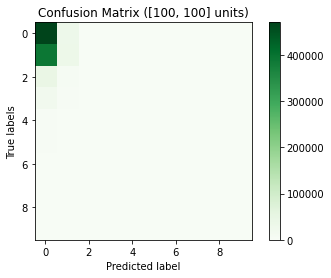

In [19]:
# Relu (2 Layers)

hidden_layer = [[100, 100]]
prediction = {}

for l in hidden_layer:
    temp = []
    model = NN_architecture(LEARNING_RATE, BATCH_SIZE, NUMBER_OF_FEATURES, l, NUMBER_OF_OUTPUTS, MIN_LOSS, EPSILON, False)
    model.run(1000,Xtrain, Ytrain,'relu')
    t = round(model.training_time,3)
    print("Training time: {}s".format(t))
    
    y_class_train, y_pred_train = model.predict(Xtrain,'relu')
    error = model.loss_function(y_class_train, Ytrain)
    train_a = round(100*accuracy_score(y_pred_train, np.argmax(Ytrain,axis=1)),3)
    print("Train Accuracy: {}%, Error: {}".format(train_a, error))

    y_class_test, y_pred_test = model.predict(Xtest,'relu')
    error2 = model.loss_function(y_class_test, Ytest)
    test_a = round(100*accuracy_score(y_pred_test, np.argmax(Ytest,axis=1)),3)
    print("Test Accuracy: {}%, Error: {}".format(test_a, error2))

    y_conf = np.argmax(Ytest, axis=1)
    confusion_matrix = np.zeros((NUMBER_OF_TARGET_CLASS,NUMBER_OF_TARGET_CLASS))
    for i in range(Ytest.shape[0]):
        confusion_matrix[y_conf[i]][y_pred_test[i]] += 1

    confusion_matrix = confusion_matrix.astype(int)
    temp = [t, train_a, test_a, confusion_matrix]
    prediction[str(l[0])+"_"+str(l[1])] = temp

    # print(confusion_matrix)
    draw_conf_matrix(confusion_matrix, l, "../output/conf_matrix_2_layers_relu_" + str(l[0]) + "_" + str(l[1]) + ".jpg")


(25010,)


In [36]:
# Part E: MLPClassifier
start_time = time.time()
# clf = MLPClassifier(random_state=1, hidden_layer_sizes=(100,100), solver='adam', activation="relu", learning_rate= "adaptive", max_iter=1000).fit(Xtrain, Ytrain)
clf = MLPClassifier(solver='sgd', hidden_layer_sizes=(100,100), activation = 'relu', max_iter=1000, learning_rate='adaptive').fit(Xtrain,np.argmax(Ytrain,axis=1))
end_time = time.time()

print("Training time: {}s".format(round(end_time-start_time,5)))

Training time: 1735.21853s


In [37]:
def accuracy(y1, y2):
    count = 0.0
    for i in range(y2.shape[0]):        
        if y1[i] == y2[i]:
            count+=1.0
    return (count)/(float(y2.shape[0]))

In [38]:
y_pred_train_mlp = clf.predict(Xtrain)
train_accuracy_mlp = round(100*accuracy(y_pred_train_mlp, np.argmax(Ytrain,axis=1)),5)
print("Train Accuracy: {}%".format(train_accuracy_mlp))
      
y_pred_test_mlp = clf.predict(Xtest)
test_accuracy_mlp = round(100*accuracy(y_pred_test_mlp, np.argmax(Ytest,axis=1)),5)
print("Test Accuracy: {}%".format(test_accuracy_mlp))

Train Accuracy: 99.43223%
Test Accuracy: 97.3983%


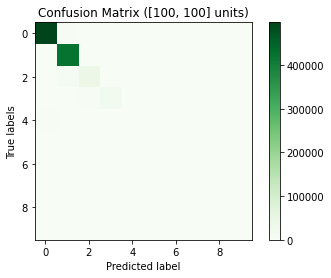

In [41]:
y_conf_MLP = np.argmax(Ytest, axis=1)
confusion_matrix = np.zeros((NUMBER_OF_TARGET_CLASS,NUMBER_OF_TARGET_CLASS))
for i in range(Ytest.shape[0]):
    confusion_matrix[y_conf_MLP[i]][y_pred_test_mlp[i]] += 1

confusion_matrix = confusion_matrix.astype(int)
draw_conf_matrix(confusion_matrix, l, "../output/conf_matrix_RELU_100_100_MLP.jpg")

In [39]:
for i in y_pred_train_mlp:
    print(i,end=" ")

1 1 1 1 1 1 1 1 1 5 1 0 0 0 1 0 0 0 0 1 1 0 1 1 1 1 1 1 0 0 3 0 0 0 0 0 1 1 0 1 1 1 1 0 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 2 0 1 0 0 1 0 0 0 1 1 1 0 1 5 1 2 1 2 1 1 0 0 0 0 0 1 0 0 0 0 1 0 1 1 0 1 2 3 1 1 0 1 1 1 0 0 1 1 3 0 1 0 0 1 0 0 1 0 1 1 0 0 1 0 1 1 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 1 2 0 1 0 1 0 1 1 1 0 0 1 0 0 1 0 1 1 0 0 0 1 0 1 0 0 0 1 1 0 1 0 0 0 0 1 1 1 1 0 0 1 0 0 1 0 0 0 0 1 0 1 1 1 1 0 1 0 1 0 0 0 1 0 0 1 0 1 1 0 0 0 1 0 0 1 0 1 0 1 1 1 0 0 1 1 0 2 1 2 0 0 2 1 1 0 1 1 1 1 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 2 0 0 0 0 0 0 1 1 0 1 1 3 0 1 0 0 0 0 1 1 1 0 0 1 0 0 1 1 1 0 1 0 0 0 0 1 0 2 0 0 3 0 0 0 0 0 2 0 1 3 0 1 2 1 0 1 1 1 3 1 0 1 0 0 0 0 1 1 1 1 0 1 1 1 1 2 0 0 0 3 1 0 0 0 1 0 1 1 1 1 1 2 1 1 3 0 0 0 0 0 1 0 0 1 1 1 1 1 0 0 0 0 1 1 1 0 0 0 0 1 1 0 2 0 0 1 0 0 0 0 1 2 0 1 0 0 3 1 0 0 1 1 0 1 0 0 1 1 0 0 0 1 0 0 1 1 1 3 0 1 3 2 0 0 0 2 0 1 1 1 0 0 0 0 0 0 1 1 0 0 2 1 0 1 0 0 0 3 0 3 0 0 1 1 3 1 0 1 1 0 0 1 1 3 0 1 2 1 1 0 1 

In [40]:
for i in y_pred_test_mlp:
    print(i,end=" ")

0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 1 1 0 0 0 1 0 0 1 0 1 0 2 0 0 0 1 0 1 1 0 0 1 0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 2 1 2 0 1 0 1 2 0 1 1 0 1 1 0 1 0 0 1 1 1 0 0 1 0 0 0 0 0 1 1 0 1 0 1 1 2 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 0 0 0 0 2 1 1 0 1 0 1 1 1 1 1 0 1 0 0 0 0 1 0 0 0 0 2 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 1 0 1 0 1 2 1 0 0 1 1 1 0 0 1 1 1 0 0 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 1 1 1 1 0 1 1 1 1 0 1 1 0 0 0 1 1 1 1 0 0 0 1 0 0 1 1 1 0 0 0 1 0 0 0 0 1 1 1 1 1 1 0 1 0 1 0 1 0 3 0 0 1 0 1 0 1 1 1 1 0 0 0 1 0 1 0 1 1 0 1 1 1 1 0 1 0 1 1 0 1 0 0 0 0 1 1 1 0 0 1 0 1 1 1 0 0 0 1 0 0 0 1 0 0 2 1 1 0 1 0 0 1 1 1 0 0 1 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 1 1 1 1 0 0 1 0 1 0 0 1 1 0 0 0 1 0 1 0 1 1 2 0 0 1 0 0 0 0 1 0 0 1 1 1 0 0 1 1 0 1 0 0 0 2 2 1 1 0 0 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 0 1 1 1 0 0 0 1 0 1 0 1 1 0 0 0 1 0 0 1 1 0 0 1 1 0 0 0 3 1 0 0 2 0 0 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 2 0 1 1 1 1 1 0 0 0 0 1 1 1 3 3 1 1 0 1 0 1 1 0 0 3 0 1 0 

KeyboardInterrupt: 

In [ ]:
# y_class_train, y_pred_train = model.predict(Xtrain,'sigmoid')
# error = model.loss_function(y_class_train, Ytrain)
# print("Train Accuracy: {}%, Error: {}".format(round(100*accuracy_score(y_pred_train, np.argmax(Ytrain,axis=1)),3), error))

# y_class_test, y_pred_test = model.predict(Xtest,'sigmoid')
# error2 = model.loss_function(y_class_test, Ytest)
# print("Test Accuracy: {}%, Error: {}".format(round(100*accuracy_score(y_pred_test, np.argmax(Ytest,axis=1)),3), error2))

# y_conf = np.argmax(Ytest, axis=1)
# confusion_matrix = np.zeros((NUMBER_OF_TARGET_CLASS,NUMBER_OF_TARGET_CLASS))
# for i in range(Ytest.shape[0]):
#     confusion_matrix[y_conf[i]][y_pred_test[i]] += 1

# confusion_matrix = confusion_matrix.astype(int)

# print(confusion_matrix)

# #  5  10  15  20  25
# # 51, 55, 55  55  50

In [74]:
for i in model.params:
    print(i,np.max(model.params[i]), np.min(model.params[i]), model.params[i].shape)
print()

for i in model.backward_prop:
    print(i,np.max(model.backward_prop[i]), np.min(model.backward_prop[i]), model.backward_prop[i].shape)
print()    

for i in model.forward_prop:
    print(i,np.max(model.forward_prop[i]), np.min(model.forward_prop[i]), model.forward_prop[i].shape)
print()


W1 6.894579202109187 -6.2474232377870385 (25, 85)
b1 2.80965195554198 -0.9961111575942798 (25, 1)
W2 16.169921747711975 -16.538051311873154 (10, 25)
b2 0.9072029440521768 -6.285372628642964 (10, 1)

dz2 0.993942830151998 -0.9974334852704684 (10, 100)
dz1 3.0067766371110576 -3.1953112242979786 (25, 100)

a0 1.0 0.0 (85, 100)
a1 0.99999994498448 4.894478729210794e-05 (25, 100)
a2 0.9997769766235483 3.1368707082357472e-09 (10, 100)



1 (5, 25010)
2 (10, 25010)
0.3425029988004798 0.8999999765695527
1 (5, 1000000)
2 (10, 1000000)
0.340879 0.8999999768439552


In [108]:
print(y_class_train[1], Ytrain[1])

[0.09774662 0.05943147 0.13015246 0.06003993 0.06181143 0.06969242
 0.14298412 0.12182448 0.13628063 0.12003645] [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [99]:
model2 = NN_architecture(LEARNING_RATE,BATCH_SIZE,NUMBER_OF_INPUTS,[5, 5],NUMBER_OF_OUTPUTS)
model2.run(1000, EPSILON, Xtrain, Ytrain,'relu')
print("Training time: {}s".format(round(model2.training_time,3)))

Training phase ... 
Epoch: 10, Error: 1.3209447245451744
Epoch: 20, Error: 1.309657894758027
Epoch: 30, Error: 1.2698166477909654
Epoch: 40, Error: 1.3050447677498611
Epoch: 50, Error: 3.726864440979116
Epoch: 60, Error: 1.2916355433426845
Epoch: 70, Error: 1.333688563643145
Epoch: 80, Error: 1.268991924825986
Epoch: 90, Error: 1.5195353628179034
Epoch: 100, Error: nan
Training time: 13.821s


In [100]:
y_class_train, y_pred_train = model2.predict(Xtrain,'relu')
error = model2.loss_function(y_class_train, Ytrain)
print("Train Accuracy: {}%, Error: {}".format(round(100*accuracy_score(y_pred_train, np.argmax(Ytrain,axis=1)),3), error))

y_class_test, y_pred_test = model2.predict(Xtest,'relu')
error2 = model2.loss_function(y_class_test, Ytest)
print("Test Accuracy: {}%, Error: {}".format(round(100*accuracy_score(y_pred_test, np.argmax(Ytest,axis=1)),3), error2))

y_conf = np.argmax(Ytest, axis=1)
confusion_matrix = np.zeros((10,10))
for i in range(Ytest.shape[0]):
    confusion_matrix[y_conf[i]][y_pred_test[i]] += 1

confusion_matrix = confusion_matrix.astype(int)

print(confusion_matrix)

#  5  10  15  20  25
# 51, 55, 55  55  50

Train Accuracy: 49.952%, Error: nan
Test Accuracy: 50.121%, Error: nan
[[501209      0      0      0      0      0      0      0      0      0]
 [422498      0      0      0      0      0      0      0      0      0]
 [ 47622      0      0      0      0      0      0      0      0      0]
 [ 21121      0      0      0      0      0      0      0      0      0]
 [  3885      0      0      0      0      0      0      0      0      0]
 [  1996      0      0      0      0      0      0      0      0      0]
 [  1424      0      0      0      0      0      0      0      0      0]
 [   230      0      0      0      0      0      0      0      0      0]
 [    12      0      0      0      0      0      0      0      0      0]
 [     3      0      0      0      0      0      0      0      0      0]]


In [42]:
for i in model2.backward_prop:
    print(i,np.max(model2.backward_prop[i]), np.min(model2.backward_prop[i]), model2.backward_prop[i].shape)
print()

for i in model2.forward_prop:
    print(i,np.max(model2.forward_prop[i]), np.min(model2.forward_prop[i]), model2.forward_prop[i].shape)
print()

for i in model2.params:
    print(i,np.max(model2.params[i]), np.min(model2.params[i]), model2.params[i].shape)

dz4 1.0 -1.0 (10, 100)
dz3 6.435164271970555e+42 -4.404224181042292 (10, 100)
dz2 8.815363775156895e+84 -3.502298235246524e+42 (50, 100)
dz1 1.8566504146402347e+127 -1.0062145051098991e+85 (70, 100)
dz0 2.961153975535918e+169 4.476963190857688e+167 (85, 100)

a0 1.0 0.0 (85, 100)
z1 1.7200192885385603e+42 -1.4085656221727102e+28 (70, 100)
a1 1.7200192885385603e+42 -0.0 (70, 100)
z2 5.719136015978563e+84 -3.3449375096514033e+70 (50, 100)
a2 5.719136015978563e+84 -0.0 (50, 100)
z3 3.0859791960474724e+127 -2.210107472982474e+113 (10, 100)
a3 3.0859791960474724e+127 -0.0 (10, 100)
z4 2.9184023788594952e+169 -3.2059813725977796e+168 (10, 100)
a4 1.0 0.0 (10, 100)

W1 5.187071734070013e+125 -2.811141384889173e+83 (70, 85)
b1 1.6732545734748368e+126 -9.068228511386736e+83 (70, 1)
W2 1.235903635889553e+126 -4.910180944669756e+83 (50, 70)
b2 7.944601545511659e+83 -3.1563489247030058e+41 (50, 1)
W3 2.9998608977374687e+126 -1.698756360041152e+84 (10, 50)
b3 5.799512910039699e+41 -2.27249621385059